In [ ]:
# !pip3 install igraph
# pip install pymde
# !pip install scanpy
# !conda install -c conda-forge leidenalg
#%pip install hyperopt "ray[tune]"
#!pip install -U ipywidgets

In [29]:
import scanpy as sc
import scvi
import anndata as ad
from scvi.model.utils import mde
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from scvi.autotune import ModelTuner
from ray import tune
import ray
seed = 9999
np.random.seed(seed)

In [2]:
adata = ad.read_h5ad("h5ad_data/RasV.h5ad")
#adata = sc.read('h5ad_data\RasV_ingr_scvi.h5ad')

In [3]:
adata.obs = adata.obs.loc[:, ~adata.obs.columns.str.startswith('DF')]
## here i just had some extra metadata column that idont need aymroe

In [4]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,condition,replicate,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.08,seurat_clusters,SCT_snn_res.0.07,batch
ctl_1_AAACCCAAGAAGTCTA-1,NASH_HCC_RASV,6545.0,2666,ctl,1,6.661574,6488.0,2658,1,1,1,ctl_1
ctl_1_AAACCCAAGAGCAGTC-1,NASH_HCC_RASV,7690.0,2660,ctl,1,6.176853,6819.0,2644,2,2,2,ctl_1
ctl_1_AAACCCAAGCCTCATA-1,NASH_HCC_RASV,16496.0,4806,ctl,1,2.764306,6135.0,2748,3,3,3,ctl_1
ctl_1_AAACCCAAGGTCATCT-1,NASH_HCC_RASV,9218.0,3493,ctl,1,3.070080,6960.0,3484,1,1,1,ctl_1
ctl_1_AAACCCAAGGTCGACA-1,NASH_HCC_RASV,8313.0,2788,ctl,1,3.969686,6917.0,2769,3,3,3,ctl_1
...,...,...,...,...,...,...,...,...,...,...,...,...
end_3_TTTGTTGCATCGATGT-1,NASH_HCC_RASV,1014.0,503,end,3,7.790927,5386.0,1285,4,2,2,end_3
end_3_TTTGTTGTCGACCATA-1,NASH_HCC_RASV,19197.0,4797,end,3,1.604417,6610.0,2674,2,4,4,end_3
end_3_TTTGTTGTCGAGTCTA-1,NASH_HCC_RASV,5713.0,2004,end,3,3.010677,6161.0,1990,7,7,7,end_3
end_3_TTTGTTGTCGCAGTCG-1,NASH_HCC_RASV,5445.0,2612,end,3,11.533517,5941.0,2598,1,1,1,end_3


In [5]:
adata.layers["counts"] = adata.X.copy()

In [6]:
adata.X.shape

(73268, 24461)

## Normalize the data ( not for inputing them on ScVI model though!)
highly variable genes can be inputed in the model

In [ ]:
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# adata.raw= adata

In [ ]:
#sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, layer = "counts", flavor= 'seurat_v3', batch_key = "batch")

## Model setup and train! skip if i already trained it

# 1. With Hyper parameter tuning

In [ ]:
model = scvi.model.SCVI

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch", continuous_covariate_keys =  ["percent.mt","nCount_RNA"])

In [ ]:
tuner = scvi.autotune.ModelTuner(model)

In [ ]:
tuner.info()

In [ ]:
ray.init(log_to_driver=False)
search_space ={"n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.choice([1e-4, 1e-2]),
    "gene_likelihood": tune.choice(["nb", "zinb"])}


In [ ]:
results = tuner.fit(adata, metric = "validation_loss",
                   resources = {"gpu":1, "cpu":16}, #use gpu
                   search_space = search_space, # parameter grid
                   num_samples = 1, # combinations of hyperparams
                   max_epochs = 20) # epochs for each combination


In [ ]:
best_vl = 1000
best_i = 0 
for i, res in enumerate(results.results):
    vl = res.metrics["validation_loss"]
    if vl< best_vl:
        best_vl = vl
        best_i = i

In [ ]:
results.results[best_i]




# TOP params for my rasv dataset
Result(
  metrics={'validation_loss': 8292.1689453125},
  path='/mnt/e/NKI_ScAnalysis/Analysis/scvi_log/autotune/2024-04-30_13-44-20_scvi/_trainable_bb024008_40_gene_likelihood=zinb,lr=0.0100,n_hidden=256,n_latent=30,n_layers=1_2024-04-30_14-34-48',
  filesystem='local',
  checkpoint=None
)

# 2 With standard model

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch", continuous_covariate_keys =  ["percent.mt","nCount_RNA"])

In [ ]:
# defaults
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [ ]:
# with hyper param tuning
model = scvi.model.SCVI(adata,gene_likelihood='zinb',n_hidden=256,n_latent=30,n_layers=1)
kwargs ={'lr':0.0100}

In [ ]:
model.train(max_epochs=200, early_stopping = True, plan_kwargs=kwargs)
model.save('all_genes_tuned_model')

## Load already trained models

In [45]:
#model.save(dir_path = "models/allgenes", overwrite=True)
#model = scvi.model.SCVI.load(dir_path="models/allgenes", adata=adata)
model = scvi.model.SCVI.load(dir_path="SCT/SCVI_integration/res_0.6_tuned/all_genes_tuned_model", adata=adata)

INFO     File SCT/SCVI_integration/res_0.6_tuned/all_genes_tuned_model/model.pt already downloaded                 


In [46]:
latent = model.get_latent_representation()
latent.shape

(73268, 30)

In [47]:
adata.obsm["X_scvi"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size = 1e4)

In [48]:
#adata.layers["scvi_normalized"]

In [49]:
sc.pp.neighbors(adata, use_rep = "X_scvi",)
sc.tl.umap(adata, random_state=seed)


## Clustering based on the leiden alg

In [50]:
sc.tl.leiden(adata, resolution = 0.06, random_state=seed, flavor= "igraph", n_iterations=2, directed = False)#, n_iterations=2, directed= False

## MDE(autoencoders) OR Classic pca umap for visualization!

In [51]:
adata.obsm["X_mde"] = mde(adata.obsm["X_scvi"])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


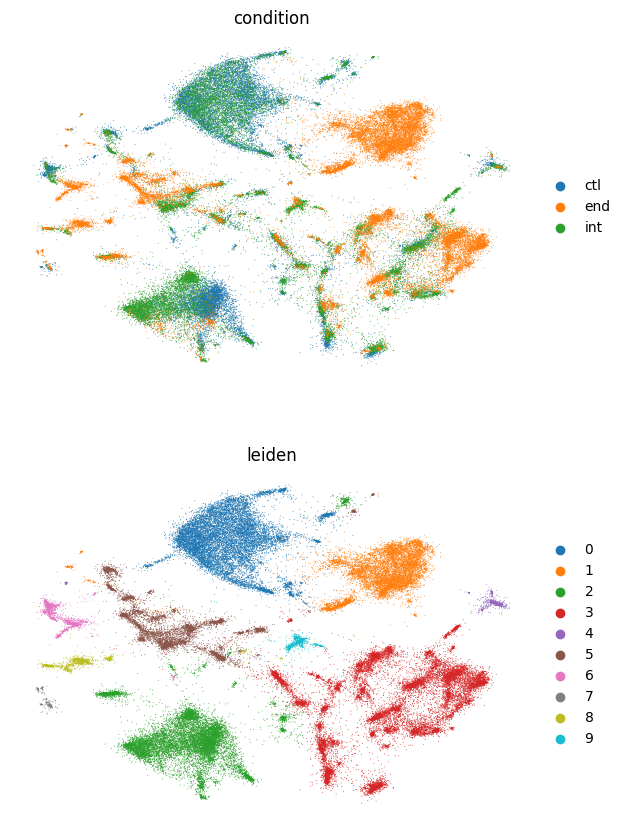

In [52]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["condition", "leiden"],
    frameon=False,
    ncols=1,
    save='mde_cell_types0_06_allgenes.pdf'
)

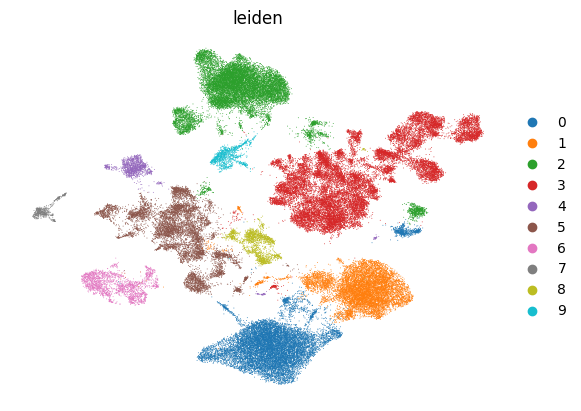

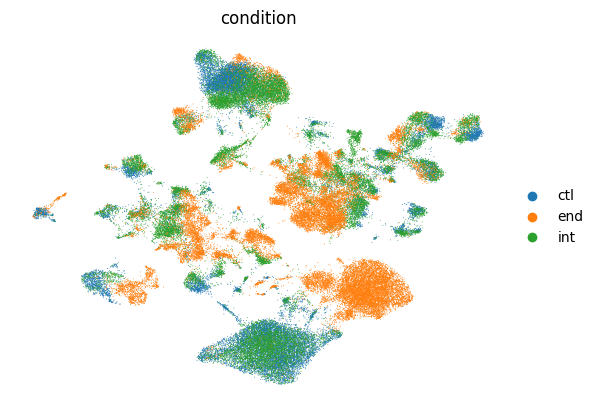

In [53]:
sc.pl.umap(adata, color = ["leiden"], frameon = False , save= "umap_cell_type.pdf")
sc.pl.umap(adata, color = ["condition"], frameon = False , save= "umap_condition.pdf")

## Markers based on DEG for each cluster against the others

In [ ]:
df = model.differential_expression(groupby = 'condition')
markers = {}
for c in adata.obs.leiden.cat.categories:
    cell_df = df.loc[df.group1 == c]
    markers[c] = cell_df.index.tolist()[:50]

In [19]:
import pandas as pd


markers_df = pd.DataFrame.from_dict(markers, orient='index').transpose()

markers_df.columns = [f"Cluster_{col}" for col in markers_df.columns]
markers_df.index = [f"Marker_{i+1}" for i in markers_df.index]
print(markers_df.head())


         Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4      Cluster_5  \
Marker_1    Gpr182     Pcdh1      Ighd     Trbc1    Cd300c           Il1b   
Marker_2      Wnt2      Cd34     Ms4a1       Lck      Fyb2  4930455G09Rik   
Marker_3   Gm36388    Igfbp3      Cd19    Ms4a4b      Pnck          Tlr13   
Marker_4    Clec4g    Rhbdl2    Klhl14      Cd96   Siglech          Kif1a   
Marker_5     Gata4    Col4a2     Il5ra     Cd247      Lrp8           Lyz2   

              Cluster_6 Cluster_7      Cluster_8 Cluster_9  
Marker_1            Gck      Xkr4          Acod1  Ighv14-2  
Marker_2       AI182371    Abca15        Slc7a11  Ighv1-52  
Marker_3  1810008I18Rik     Pkhd1          Il1f9  Igkv3-12  
Marker_4           Rida      Hypm          Rufy4    Jchain  
Marker_5      Serpina1d    Snhg11  5430425K12Rik  Igkv6-23  


In [20]:
#!pip install openpyxl
markers_df.to_excel('markers0_6scvi_allgenes_tuned.xlsx', index=True)


In [ ]:
#adata.write('RasV_ingr_scvi.h5ad')

In [ ]:
#adata = sc.read('your_filename.h5ad')

## Manual Annotation

In [54]:
cluster_cell_types = {
    "0": 'EC',         # Endothelial cells, possibly liver sinusoidal endothelial cells
    "1": 'EC',         # Vascular endothelial cells and hepatic stellate cells
    '2': 'Bcells',     # B cells
    '3': 'T',          # T cells
    '4': 'DC',         # Dendritic cells, but potentially mixed immune cells, "T" may also be considered
    '5': 'Myeloid',    # Myeloid cells, predominantly macrophages
    '6': 'Hep1/cc',    # Hepatocytes (Hep1/cc seems appropriate)
    '7': 'Hep/Cholangi',  # Cholangiocytes or bile duct cells
    '8': 'Gran',       # Neutrophils and other granulocytes
    '9': 'plasma/actB'}

In [55]:
adata.obs['cell_types'] = ''

# the new column with the corresponding cell types based on the leiden clustering numbers
for cluster_num, cell_type in cluster_cell_types.items():
    adata.obs.loc[adata.obs['leiden'] == cluster_num, 'cell_types'] = cell_type
print(adata.obs.head())

                             orig.ident  nCount_RNA  nFeature_RNA condition  \
ctl_1_AAACCCAAGAAGTCTA-1  NASH_HCC_RASV      6545.0          2666       ctl   
ctl_1_AAACCCAAGAGCAGTC-1  NASH_HCC_RASV      7690.0          2660       ctl   
ctl_1_AAACCCAAGCCTCATA-1  NASH_HCC_RASV     16496.0          4806       ctl   
ctl_1_AAACCCAAGGTCATCT-1  NASH_HCC_RASV      9218.0          3493       ctl   
ctl_1_AAACCCAAGGTCGACA-1  NASH_HCC_RASV      8313.0          2788       ctl   

                         replicate  percent.mt  nCount_SCT  nFeature_SCT  \
ctl_1_AAACCCAAGAAGTCTA-1         1    6.661574      6488.0          2658   
ctl_1_AAACCCAAGAGCAGTC-1         1    6.176853      6819.0          2644   
ctl_1_AAACCCAAGCCTCATA-1         1    2.764306      6135.0          2748   
ctl_1_AAACCCAAGGTCATCT-1         1    3.070080      6960.0          3484   
ctl_1_AAACCCAAGGTCGACA-1         1    3.969686      6917.0          2769   

                         SCT_snn_res.0.08 seurat_clusters SCT_snn_re

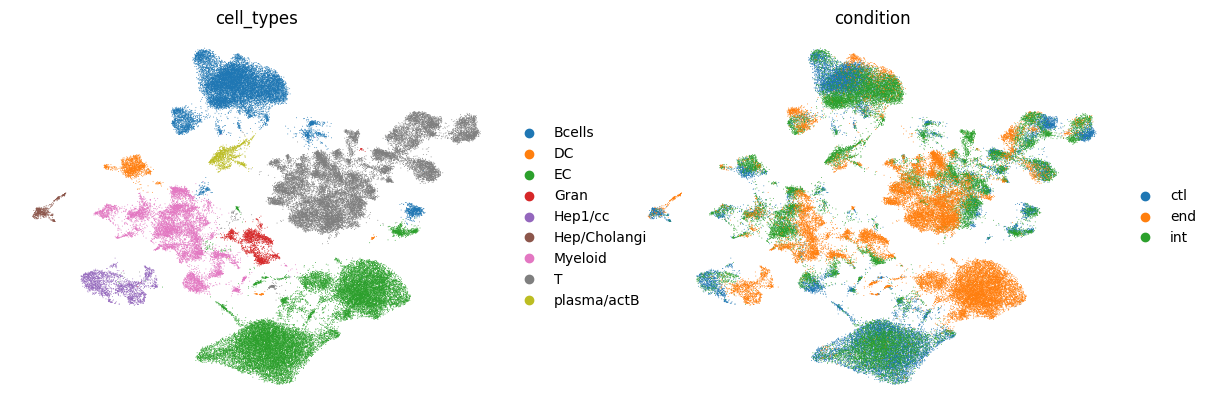

In [56]:
sc.pl.umap(adata, color=["cell_types", "condition"], frameon=False, save="annotated_scvi.png")


In [32]:
#The continous creates issue when transformed to seurat object in R so we could delete it
#del adata.obsm['_scvi_extra_continuous_covs']
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
adata.write('RasV_ingr_scvi_tuned_06.h5ad')